## PySpark Data Analysis

In [2]:
import findspark
findspark.init("C:/PROGRA~1/spark/spark-3.5.6-bin-hadoop3")


In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Test").getOrCreate()

In [16]:
# Cell 1: Import necessary libraries and initialize Spark Session
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, countDistinct, desc, to_date, rank, explode, split, lower, trim, length
from pyspark.sql.types import *
from pyspark.sql.window import Window
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("AgriculturalDataAnalysis") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()

print("Spark session created successfully!") 

Spark session created successfully!


In [20]:
# Cell 2: Load the CSV file and display basic information
# Load the dataset
df = spark.read.option("header", "true").option("inferSchema", "true").csv("C:/Users/intur/Downloads/Data Analytics_CSV.csv")

# Display basic dataset information
print("=== DATASET BASIC INFORMATION ===")
print(f"Number of rows: {df.count()}")
print(f"Number of columns: {len(df.columns)}")
print("\nColumn names:")
for col_name in df.columns:
    print(f"- {col_name}")

print("\nDataset Schema:")
df.printSchema()

print("\nFirst 5 rows:")
df.show(5, truncate=False)

=== DATASET BASIC INFORMATION ===
Number of rows: 82803
Number of columns: 13

Column names:
- StateName
- DistrictName
- BlockName
- Season
- Sector
- Category
- Crop
- QueryType
- QueryText
- KccAns
- CreatedOn
- year
- month

Dataset Schema:
root
 |-- StateName: string (nullable = true)
 |-- DistrictName: string (nullable = true)
 |-- BlockName: string (nullable = true)
 |-- Season: string (nullable = true)
 |-- Sector: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Crop: string (nullable = true)
 |-- QueryType: string (nullable = true)
 |-- QueryText: string (nullable = true)
 |-- KccAns: string (nullable = true)
 |-- CreatedOn: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)


First 5 rows:
+--------------------------------------------------------------------------------------------------------+-----------------------+---------+------+-----------+--------+---------------------+-----------------------+--------

In [22]:
# Cell 3: Data Quality Check and Missing Values Analysis
print("=== DATA QUALITY ANALYSIS ===")

# Check for missing values
print("\nMissing Values Count:")
for column in df.columns:
    null_count = df.filter(col(column).isNull()).count()
    if null_count > 0:
        print(f"{column}: {null_count}")

# Check for empty strings
print("\nEmpty Strings Count:")
for column in df.columns:
    empty_count = df.filter(col(column) == "").count()
    if empty_count > 0:
        print(f"{column}: {empty_count}")

# Check for 'NA' values
print("\n'NA' Values Count:")
for column in df.columns:
    na_count = df.filter(col(column) == "NA").count()
    if na_count > 0:
        print(f"{column}: {na_count}")

=== DATA QUALITY ANALYSIS ===

Missing Values Count:
StateName: 5
DistrictName: 32539
BlockName: 35894
Season: 36988
Sector: 43889
Category: 45340
Crop: 45789
QueryType: 46036
QueryText: 46165
KccAns: 49897
CreatedOn: 67813
year: 67861
month: 67884

Empty Strings Count:

'NA' Values Count:
BlockName: 56
Season: 36434
Sector: 504
Category: 345
Crop: 504
QueryType: 370


In [24]:
# Cell 4: Basic Statistical Summary
print("=== STATISTICAL SUMMARY ===")

# Numerical columns summary
print("Numerical Columns Summary:")
df.describe(['year', 'month']).show()

# Categorical columns summary
categorical_cols = ['StateName', 'DistrictName', 'BlockName', 'Season', 'Sector', 'Category', 'Crop', 'QueryType']

print("\nCategorical Columns Distinct Count:")
for col_name in categorical_cols:
    distinct_count = df.select(col_name).distinct().count()
    print(f"{col_name}: {distinct_count} distinct values")

=== STATISTICAL SUMMARY ===
Numerical Columns Summary:
+-------+--------------------+--------------------+
|summary|                year|               month|
+-------+--------------------+--------------------+
|  count|               14942|               14919|
|   mean|  2023.2362940069875|   4.784873949579832|
| stddev|    59.6540227412454|   29.37850662729076|
|    min| 2025-02-22: గరిష...|                CO 6|
|    max|సుగంధసాంబ (ఆర్ఎన్...|శోభిని (ఆర్ఎన్ఆర్...|
+-------+--------------------+--------------------+


Categorical Columns Distinct Count:
StateName: 26905 distinct values
DistrictName: 9450 distinct values
BlockName: 3481 distinct values
Season: 1064 distinct values
Sector: 612 distinct values
Category: 349 distinct values
Crop: 363 distinct values
QueryType: 186 distinct values


In [26]:
# Cell 5: District-wise Analysis
print("=== DISTRICT-WISE ANALYSIS ===")

# Top districts by query count
district_queries = df.groupBy("DistrictName").agg(
    count("*").alias("TotalQueries"),
    countDistinct("BlockName").alias("BlocksCovered")
).orderBy(desc("TotalQueries"))

print("Top 10 Districts by Query Count:")
district_queries.show(10, truncate=False)

# District-wise crop distribution
district_crop_dist = df.groupBy("DistrictName", "Crop").agg(
    count("*").alias("QueryCount")
).orderBy(desc("QueryCount"))

print("\nTop Crops by District:")
district_crop_dist.show(10, truncate=False)

=== DISTRICT-WISE ANALYSIS ===
Top 10 Districts by Query Count:
+--------------+------------+-------------+
|DistrictName  |TotalQueries|BlocksCovered|
+--------------+------------+-------------+
|NULL          |32539       |1            |
|KAMAREDDY     |4004        |47           |
|RANGAREDDY    |2045        |45           |
|WARANGAL RURAL|2017        |24           |
|NIRMAL        |1944        |32           |
|MAHABUBABAD   |1930        |29           |
|NALGONDA      |1919        |48           |
|KHAMMAM       |1549        |43           |
|SIDDIPET      |1512        |39           |
|SANGAREDDY    |1374        |43           |
+--------------+------------+-------------+
only showing top 10 rows


Top Crops by District:
+------------+--------------+----------+
|DistrictName|Crop          |QueryCount|
+------------+--------------+----------+
|NULL        |NULL          |32539     |
|RANGAREDDY  |Others        |1443      |
|KAMAREDDY   |Soybean (bhat)|823       |
|KAMAREDDY   |Paddy (Dha

In [28]:
# Cell 6: Crop Analysis
print("=== CROP ANALYSIS ===")

# Most common crops
crop_analysis = df.groupBy("Crop").agg(
    count("*").alias("TotalQueries"),
    countDistinct("DistrictName").alias("DistrictsCovered"),
    countDistinct("QueryType").alias("QueryTypes")
).orderBy(desc("TotalQueries"))

print("Top Crops by Query Volume:")
crop_analysis.show(10, truncate=False)

# Crop category distribution
category_analysis = df.groupBy("Category").agg(
    count("*").alias("TotalQueries"),
    countDistinct("Crop").alias("CropVarieties")
).orderBy(desc("TotalQueries"))

print("\nCategory-wise Distribution:")
category_analysis.show(truncate=False)

=== CROP ANALYSIS ===
Top Crops by Query Volume:
+--------------+------------+----------------+----------+
|Crop          |TotalQueries|DistrictsCovered|QueryTypes|
+--------------+------------+----------------+----------+
|NULL          |45789       |9112            |0         |
|Paddy (Dhan)  |9537        |31              |23        |
|Others        |8733        |31              |29        |
|Cotton (Kapas)|5834        |31              |18        |
|Maize (Makka) |2728        |30              |18        |
|Soybean (bhat)|1421        |19              |17        |
|Chillies      |1095        |31              |17        |
|NA            |504         |31              |12        |
|Tomato        |452         |29              |16        |
|Mango         |443         |31              |17        |
+--------------+------------+----------------+----------+
only showing top 10 rows


Category-wise Distribution:
+---------------------+------------+-------------+
|Category             |TotalQueri

In [30]:
# Cell 7: Query Type Analysis
print("=== QUERY TYPE ANALYSIS ===")

# Most common query types
query_type_analysis = df.groupBy("QueryType").agg(
    count("*").alias("TotalQueries"),
    countDistinct("DistrictName").alias("DistrictsCovered")
).orderBy(desc("TotalQueries"))

print("Query Type Distribution:")
query_type_analysis.show(truncate=False)

# Query type by crop
query_crop_analysis = df.groupBy("QueryType", "Crop").agg(
    count("*").alias("QueryCount")
).orderBy(desc("QueryCount"))

print("\nTop Query Types by Crop:")
query_crop_analysis.show(10, truncate=False)

=== QUERY TYPE ANALYSIS ===
Query Type Distribution:
+----------------------------------------------------------------------------------------+------------+----------------+
|QueryType                                                                               |TotalQueries|DistrictsCovered|
+----------------------------------------------------------------------------------------+------------+----------------+
|NULL                                                                                    |46036       |9270            |
|Government Schemes                                                                      |7288        |31              |
|\tPlant Protection\t                                                                    |5588        |31              |
|Weather                                                                                 |4441        |31              |
|\tWater Management\t                                                                    |4257      

In [32]:
# Cell 8: Temporal Analysis
print("=== TEMPORAL ANALYSIS ===")

# Monthly query distribution
monthly_analysis = df.groupBy("month").agg(
    count("*").alias("TotalQueries"),
    countDistinct("DistrictName").alias("ActiveDistricts")
).orderBy("month")

print("Monthly Query Distribution:")
monthly_analysis.show()

# Daily query trend (using CreatedOn)
df_with_date = df.withColumn("date", to_date(col("CreatedOn")))

daily_trend = df_with_date.groupBy("date").agg(
    count("*").alias("DailyQueries")
).orderBy("date")

print("\nDaily Query Trend (First 10 days):")
daily_trend.show(10, truncate=False)

=== TEMPORAL ANALYSIS ===
Monthly Query Distribution:
+--------------------+------------+---------------+
|               month|TotalQueries|ActiveDistricts|
+--------------------+------------+---------------+
|                NULL|       67884|           9420|
|                CO 6|           1|              1|
|        Cyperus iria|           1|              1|
|             Karpuri|           1|              1|
|            Sesbania|           1|              1|
|              pepper|           1|              1|
|                 tea|           1|              1|
| కనిష్ట ఉష్ణోగ్రత...|           1|              1|
| క్లౌడ్ కవర్ః క్ల...|           1|              1|
| గరిష్ట ఉష్ణోగ్రత...|           1|              1|
|       గాలి దిశః ఎస్|           1|              1|
|  గాలి వేగంః 15 కిమీ|           1|              1|
| పంట పరిహారం వంటి...|           1|              1|
|     పూసా స్నోబాల్-1|           1|              1|
| పొటాష్ ఎరువులను ...|           4|              1|
|         

In [34]:
# Cell 9: Sector and Season Analysis
print("=== SECTOR AND SEASON ANALYSIS ===")

# Sector distribution
sector_analysis = df.groupBy("Sector").agg(
    count("*").alias("TotalQueries"),
    countDistinct("Crop").alias("CropsCovered")
).orderBy(desc("TotalQueries"))

print("Sector-wise Distribution:")
sector_analysis.show(truncate=False)

# Season analysis
season_analysis = df.groupBy("Season").agg(
    count("*").alias("TotalQueries")
).orderBy(desc("TotalQueries"))

print("\nSeason-wise Query Distribution:")
season_analysis.show(truncate=False)

=== SECTOR AND SEASON ANALYSIS ===
Sector-wise Distribution:
+-------------------------------+------------+------------+
|Sector                         |TotalQueries|CropsCovered|
+-------------------------------+------------+------------+
|NULL                           |43889       |0           |
|AGRICULTURE                    |30870       |76          |
|HORTICULTURE                   |4682        |113         |
|NA                             |504         |1           |
|2                              |390         |0           |
|2025                           |316         |0           |
|6                              |233         |0           |
|7                              |174         |0           |
|3                              |154         |0           |
|5                              |135         |0           |
|ANIMAL HUSBANDRY               |115         |12          |
|4                              |103         |0           |
|1                              |94    

In [36]:
# Cell 10: Advanced Analytics - Window Functions
print("=== ADVANCED ANALYTICS USING WINDOW FUNCTIONS ===")

# District ranking by query volume
window_spec = Window.orderBy(desc("TotalQueries"))

district_ranking = df.groupBy("DistrictName").agg(
    count("*").alias("TotalQueries")
).withColumn("rank", rank().over(window_spec))

print("District Ranking by Query Volume:")
district_ranking.show(10, truncate=False)

# Monthly trend for top crops
top_crops = df.groupBy("Crop").agg(count("*").alias("cnt")).orderBy(desc("cnt")).limit(5)
top_crop_list = [row['Crop'] for row in top_crops.collect()]

monthly_crop_trend = df.filter(col("Crop").isin(top_crop_list)) \
    .groupBy("month", "Crop") \
    .agg(count("*").alias("QueryCount")) \
    .orderBy("month", desc("QueryCount"))

print("\nMonthly Trend for Top 5 Crops:")
monthly_crop_trend.show(20, truncate=False)

=== ADVANCED ANALYTICS USING WINDOW FUNCTIONS ===
District Ranking by Query Volume:
+--------------+------------+----+
|DistrictName  |TotalQueries|rank|
+--------------+------------+----+
|NULL          |32539       |1   |
|KAMAREDDY     |4004        |2   |
|RANGAREDDY    |2045        |3   |
|WARANGAL RURAL|2017        |4   |
|NIRMAL        |1944        |5   |
|MAHABUBABAD   |1930        |6   |
|NALGONDA      |1919        |7   |
|KHAMMAM       |1549        |8   |
|SIDDIPET      |1512        |9   |
|SANGAREDDY    |1374        |10  |
+--------------+------------+----+
only showing top 10 rows


Monthly Trend for Top 5 Crops:
+-----+--------------+----------+
|month|Crop          |QueryCount|
+-----+--------------+----------+
|NULL |Paddy (Dhan)  |6091      |
|NULL |Cotton (Kapas)|4163      |
|NULL |Others        |3774      |
|NULL |Maize (Makka) |1729      |
|1    |Others        |405       |
|1    |Paddy (Dhan)  |399       |
|1    |Maize (Makka) |115       |
|1    |Cotton (Kapas)|8     

In [38]:
# Cell 11: Text Analysis - Query Patterns
print("=== QUERY TEXT ANALYSIS ===")

# Most common words in query text (basic analysis)
# Clean and split query text
query_words = df.filter(col("QueryText").isNotNull()) \
    .select(explode(split(lower(trim(col("QueryText"))), " ")).alias("word")) \
    .filter(length(col("word")) > 3) \
    .groupBy("word") \
    .agg(count("*").alias("frequency")) \
    .orderBy(desc("frequency"))

print("Most Common Words in Query Text:")
query_words.show(20, truncate=False)

=== QUERY TEXT ANALYSIS ===
Most Common Words in Query Text:
+-----------+---------+
|word       |frequency|
+-----------+---------+
|query      |21513    |
|farmer     |20937    |
|asked      |20293    |
|weather    |13433    |
|management |9326     |
|paddy      |4997     |
|kisan      |4088     |
|call       |3520     |
|about      |3107     |
|nutrient   |1704     |
|status     |1648     |
|samman     |1557     |
|information|1528     |
|cotton     |1517     |
|weed       |1487     |
|nidhi      |1479     |
|test       |1223     |
|scheme     |1214     |
|crop       |1198     |
|sowing     |1191     |
+-----------+---------+
only showing top 20 rows



In [40]:
# Cell 12: Complex Aggregations - Multiple Dimensions
print("=== MULTI-DIMENSIONAL ANALYSIS ===")

# District, Crop, and Query Type combination
multi_dim_analysis = df.groupBy("DistrictName", "Crop", "QueryType").agg(
    count("*").alias("QueryCount")
).orderBy(desc("QueryCount"))

print("Top Combinations (District-Crop-QueryType):")
multi_dim_analysis.show(15, truncate=False)

# Pivot table: Query types by crop category
pivot_analysis = df.groupBy("Category").pivot("QueryType").agg(
    count("*").alias("count")
).fillna(0)

print("\nPivot Table: Query Types by Category:")
pivot_analysis.show(truncate=False)

=== MULTI-DIMENSIONAL ANALYSIS ===
Top Combinations (District-Crop-QueryType):
+---------------------------------------------+--------------+----------------------------+----------+
|DistrictName                                 |Crop          |QueryType                   |QueryCount|
+---------------------------------------------+--------------+----------------------------+----------+
|NULL                                         |NULL          |NULL                        |32539     |
|RANGAREDDY                                   |Others        |Government Schemes          |1152      |
|KAMAREDDY                                    |Soybean (bhat)|\tWater Management\t        |500       |
|NALGONDA                                     |Others        |Government Schemes          |384       |
|KAMAREDDY                                    |Cotton (Kapas)|\tWater Management\t        |351       |
|KAMAREDDY                                    |Maize (Makka) |\tWater Management\t        |345   

## Pandas For Visualization

In [42]:
# Cell 13: Convert to Pandas for Visualization
print("=== CONVERTING TO PANDAS FOR VISUALIZATION ===")

# Convert Spark DataFrame to Pandas
pandas_df = df.toPandas()

print(f"Pandas DataFrame shape: {pandas_df.shape}")
print("\nPandas DataFrame Info:")
print(pandas_df.info())

# Set up visualization style
plt.style.use('default')
sns.set_palette("husl")

=== CONVERTING TO PANDAS FOR VISUALIZATION ===
Pandas DataFrame shape: (82803, 13)

Pandas DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82803 entries, 0 to 82802
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   StateName     82798 non-null  object
 1   DistrictName  50264 non-null  object
 2   BlockName     46909 non-null  object
 3   Season        45815 non-null  object
 4   Sector        38914 non-null  object
 5   Category      37463 non-null  object
 6   Crop          37014 non-null  object
 7   QueryType     36767 non-null  object
 8   QueryText     36638 non-null  object
 9   KccAns        32906 non-null  object
 10  CreatedOn     14990 non-null  object
 11  year          14942 non-null  object
 12  month         14919 non-null  object
dtypes: object(13)
memory usage: 8.2+ MB
None


=== TOP CROPS AND CATEGORY VISUALIZATION ===


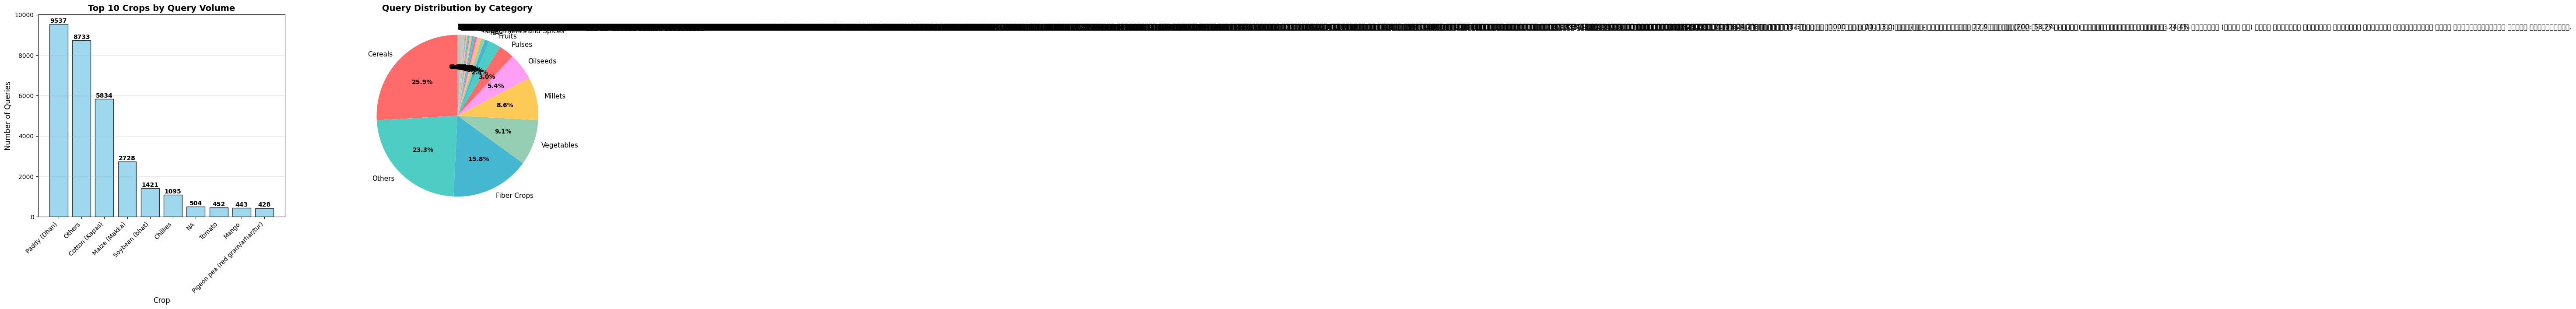


Top Crops Count:
  Paddy (Dhan): 9537 queries
  Others: 8733 queries
  Cotton (Kapas): 5834 queries
  Maize (Makka): 2728 queries
  Soybean (bhat): 1421 queries
  Chillies: 1095 queries
  NA: 504 queries
  Tomato: 452 queries
  Mango: 443 queries
  Pigeon pea (red gram/arhar/tur): 428 queries

Category Distribution:
  Cereals: 9702 queries (11.7%)
  Others: 8737 queries (10.6%)
  Fiber Crops: 5912 queries (7.1%)
  Vegetables: 3422 queries (4.1%)
  Millets: 3214 queries (3.9%)
  Oilseeds: 2030 queries (2.5%)
  Pulses: 1141 queries (1.4%)
  Fruits: 896 queries (1.1%)
  NA: 345 queries (0.4%)
  Condiments and Spices: 280 queries (0.3%)
  2025: 201 queries (0.2%)
  Green Manure: 141 queries (0.2%)
  Plantation Crops: 136 queries (0.2%)
  Animal: 106 queries (0.1%)
  Flowers: 94 queries (0.1%)
  5: 74 queries (0.1%)
  6: 68 queries (0.1%)
  40: 55 queries (0.1%)
  Drug and Narcotics: 53 queries (0.1%)
  2: 53 queries (0.1%)
  7: 51 queries (0.1%)
  Fiber Crop: 46 queries (0.1%)
  80 రోజులక

In [48]:
# Cell 14: Top Crops Visualization - IMPROVED VERSION
print("=== TOP CROPS AND CATEGORY VISUALIZATION ===")

# Create separate figures for better readability
plt.figure(figsize=(16, 6))

# Plot 1: Top Crops by Query Count
plt.subplot(1, 2, 1)
top_crops = pandas_df['Crop'].value_counts().head(10)
bars = plt.bar(range(len(top_crops)), top_crops.values, color='skyblue', edgecolor='black', alpha=0.8)
plt.title('Top 10 Crops by Query Volume', fontweight='bold', fontsize=14)
plt.xlabel('Crop', fontsize=12)
plt.ylabel('Number of Queries', fontsize=12)
plt.xticks(range(len(top_crops)), top_crops.index, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Category Distribution
plt.subplot(1, 2, 2)
category_dist = pandas_df['Category'].value_counts()
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4', '#feca57', '#ff9ff3']
wedges, texts, autotexts = plt.pie(category_dist.values, labels=category_dist.index, 
                                   autopct='%1.1f%%', startangle=90, colors=colors,
                                   textprops={'fontsize': 11})
plt.title('Query Distribution by Category', fontweight='bold', fontsize=14)

# Make autopct text bold
for autotext in autotexts:
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

plt.tight_layout()
plt.show()

# Display the actual numbers for reference
print("\nTop Crops Count:")
for crop, count in top_crops.items():
    print(f"  {crop}: {count} queries")

print("\nCategory Distribution:")
for category, count in category_dist.items():
    print(f"  {category}: {count} queries ({count/len(pandas_df)*100:.1f}%)")

=== DISTRICT AND QUERY TYPE ANALYSIS ===


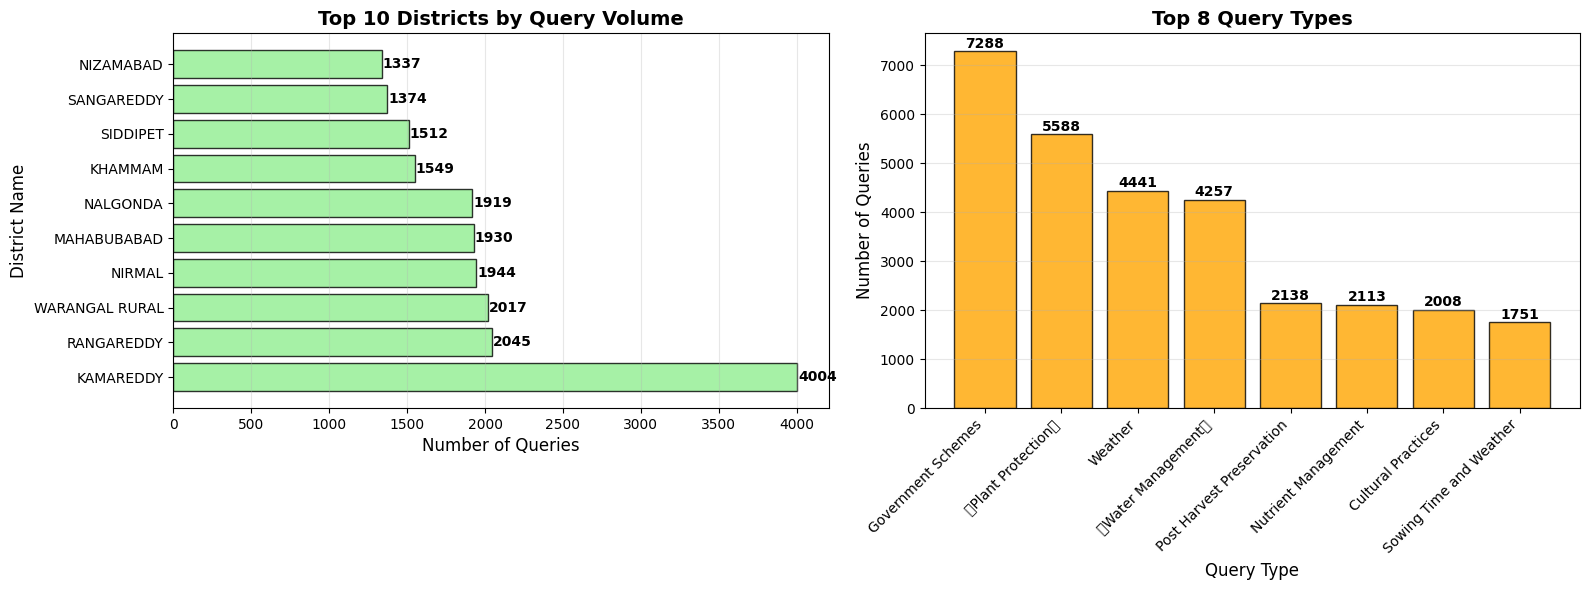


Top Districts Count:
  KAMAREDDY: 4004 queries
  RANGAREDDY: 2045 queries
  WARANGAL RURAL: 2017 queries
  NIRMAL: 1944 queries
  MAHABUBABAD: 1930 queries
  NALGONDA: 1919 queries
  KHAMMAM: 1549 queries
  SIDDIPET: 1512 queries
  SANGAREDDY: 1374 queries
  NIZAMABAD: 1337 queries

Top Query Types Count:
  Government Schemes: 7288 queries
  	Plant Protection	: 5588 queries
  Weather: 4441 queries
  	Water Management	: 4257 queries
  Post Harvest Preservation: 2138 queries
  Nutrient Management: 2113 queries
  Cultural Practices: 2008 queries
  Sowing Time and Weather: 1751 queries


In [50]:
# Cell 15: District and Query Type Analysis - IMPROVED VERSION
print("=== DISTRICT AND QUERY TYPE ANALYSIS ===")

plt.figure(figsize=(16, 6))

# Plot 1: Top Districts
plt.subplot(1, 2, 1)
top_districts = pandas_df['DistrictName'].value_counts().head(10)
bars = plt.barh(range(len(top_districts)), top_districts.values, 
                color='lightgreen', edgecolor='black', alpha=0.8)
plt.title('Top 10 Districts by Query Volume', fontweight='bold', fontsize=14)
plt.xlabel('Number of Queries', fontsize=12)
plt.ylabel('District Name', fontsize=12)
plt.yticks(range(len(top_districts)), top_districts.index)
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height()/2.,
             f'{int(width)}', ha='left', va='center', fontweight='bold')

# Plot 2: Query Type Distribution
plt.subplot(1, 2, 2)
query_types = pandas_df['QueryType'].value_counts().head(8)
bars = plt.bar(range(len(query_types)), query_types.values, 
               color='orange', edgecolor='black', alpha=0.8)
plt.title('Top 8 Query Types', fontweight='bold', fontsize=14)
plt.xlabel('Query Type', fontsize=12)
plt.ylabel('Number of Queries', fontsize=12)
plt.xticks(range(len(query_types)), query_types.index, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Display the actual numbers for reference
print("\nTop Districts Count:")
for district, count in top_districts.items():
    print(f"  {district}: {count} queries")

print("\nTop Query Types Count:")
for query_type, count in query_types.items():
    print(f"  {query_type}: {count} queries")

=== TEMPORAL AND SECTOR ANALYSIS ===


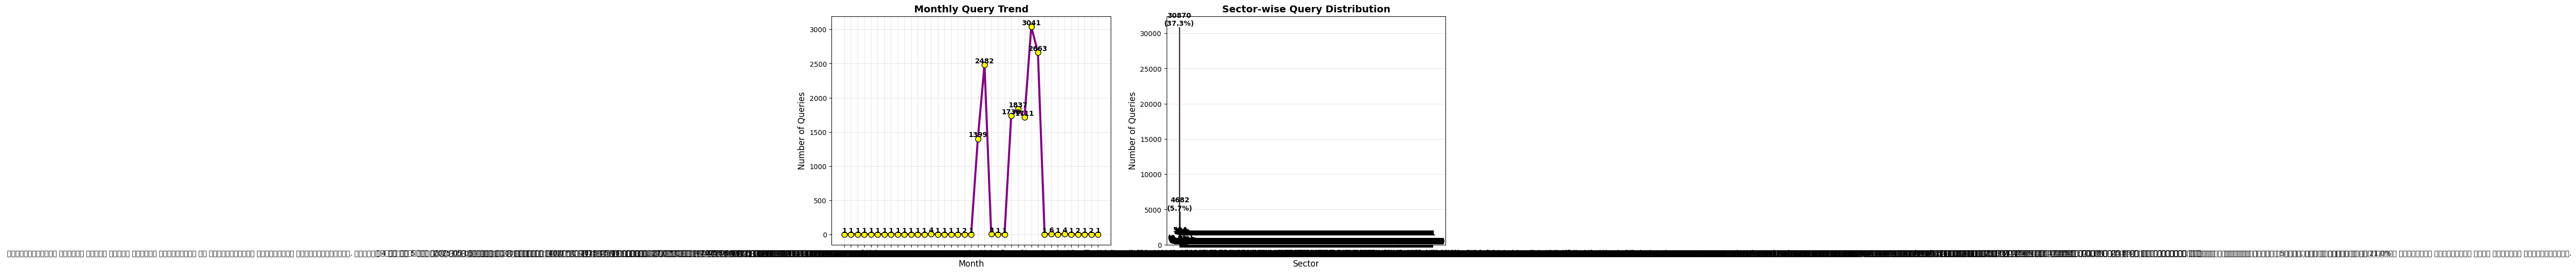


Monthly Distribution:
  Month  CO 6: 1 queries
  Month  Cyperus iria: 1 queries
  Month  Karpuri: 1 queries
  Month  Sesbania: 1 queries
  Month  pepper: 1 queries
  Month  tea: 1 queries
  Month  కనిష్ట ఉష్ణోగ్రతః 23 డిగ్రీల సెల్సియస్: 1 queries
  Month  క్లౌడ్ కవర్ః క్లియర్ స్కైస్-శుక్రవారం: 1 queries
  Month  గరిష్ట ఉష్ణోగ్రతలుః 39°సీ: 1 queries
  Month  గాలి దిశః ఎస్: 1 queries
  Month  గాలి వేగంః 15 కిమీ: 1 queries
  Month  పంట పరిహారం వంటి వివరాలు కూడా ఈ కార్డులో ఉంటాయి": 1 queries
  Month  పూసా స్నోబాల్-1: 1 queries
  Month  పొటాష్ ఎరువులను మామిడి కాయలు గోళీ సైజులో ఉన్నప్పుడు వేసుకోవాలి.: 4 queries
  Month  ప్రద్యుమ్న: 1 queries
  Month  మేఘావరణంః పాక్షికంగా మేఘావృతమైన ఆకాశం-గురువారం: 1 queries
  Month  మేఘావృతంః పాక్షికంగా మేఘావృతమై-గురువారం: 1 queries
  Month  యం.టి.హెచ్-6 : 1 queries
  Month  రైతు సంక్షేమ శాఖ మంత్రికి చూపించి వివరించడానికి సన్నాహాలు చేస్తున్నామన్నారు. టార్గెట్‌ 1000 రకం వరి వండగం విడుదలైతే వరి పరిశోధన: 2 queries
  Month  సెస్బానియా: 1 queries
  Month 1: 1399

In [52]:
# Cell 16: Monthly Trend and Sector Analysis - IMPROVED VERSION
print("=== TEMPORAL AND SECTOR ANALYSIS ===")

plt.figure(figsize=(16, 6))

# Plot 1: Monthly query distribution
plt.subplot(1, 2, 1)
monthly_trend = pandas_df['month'].value_counts().sort_index()
plt.plot(monthly_trend.index, monthly_trend.values, marker='o', linewidth=3, 
         markersize=8, color='purple', markerfacecolor='yellow', markeredgecolor='black')
plt.title('Monthly Query Trend', fontweight='bold', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Queries', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(monthly_trend.index)

# Add value labels on points
for month, count in monthly_trend.items():
    plt.text(month, count + 5, f'{count}', ha='center', va='bottom', 
             fontweight='bold', fontsize=10)

# Plot 2: Sector distribution
plt.subplot(1, 2, 2)
sector_dist = pandas_df['Sector'].value_counts()
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
bars = plt.bar(range(len(sector_dist)), sector_dist.values, 
               color=colors, edgecolor='black', alpha=0.8)
plt.title('Sector-wise Query Distribution', fontweight='bold', fontsize=14)
plt.xlabel('Sector', fontsize=12)
plt.ylabel('Number of Queries', fontsize=12)
plt.xticks(range(len(sector_dist)), sector_dist.index)
plt.grid(axis='y', alpha=0.3)

# Add value labels and percentages on bars
total_queries = len(pandas_df)
for i, bar in enumerate(bars):
    height = bar.get_height()
    percentage = (height / total_queries) * 100
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}\n({percentage:.1f}%)', ha='center', va='bottom', 
             fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# Display the actual numbers for reference
print("\nMonthly Distribution:")
for month, count in monthly_trend.items():
    print(f"  Month {month}: {count} queries")

print("\nSector Distribution:")
for sector, count in sector_dist.items():
    print(f"  {sector}: {count} queries ({count/total_queries*100:.1f}%)")

=== CROP vs QUERY TYPE HEATMAP ANALYSIS ===


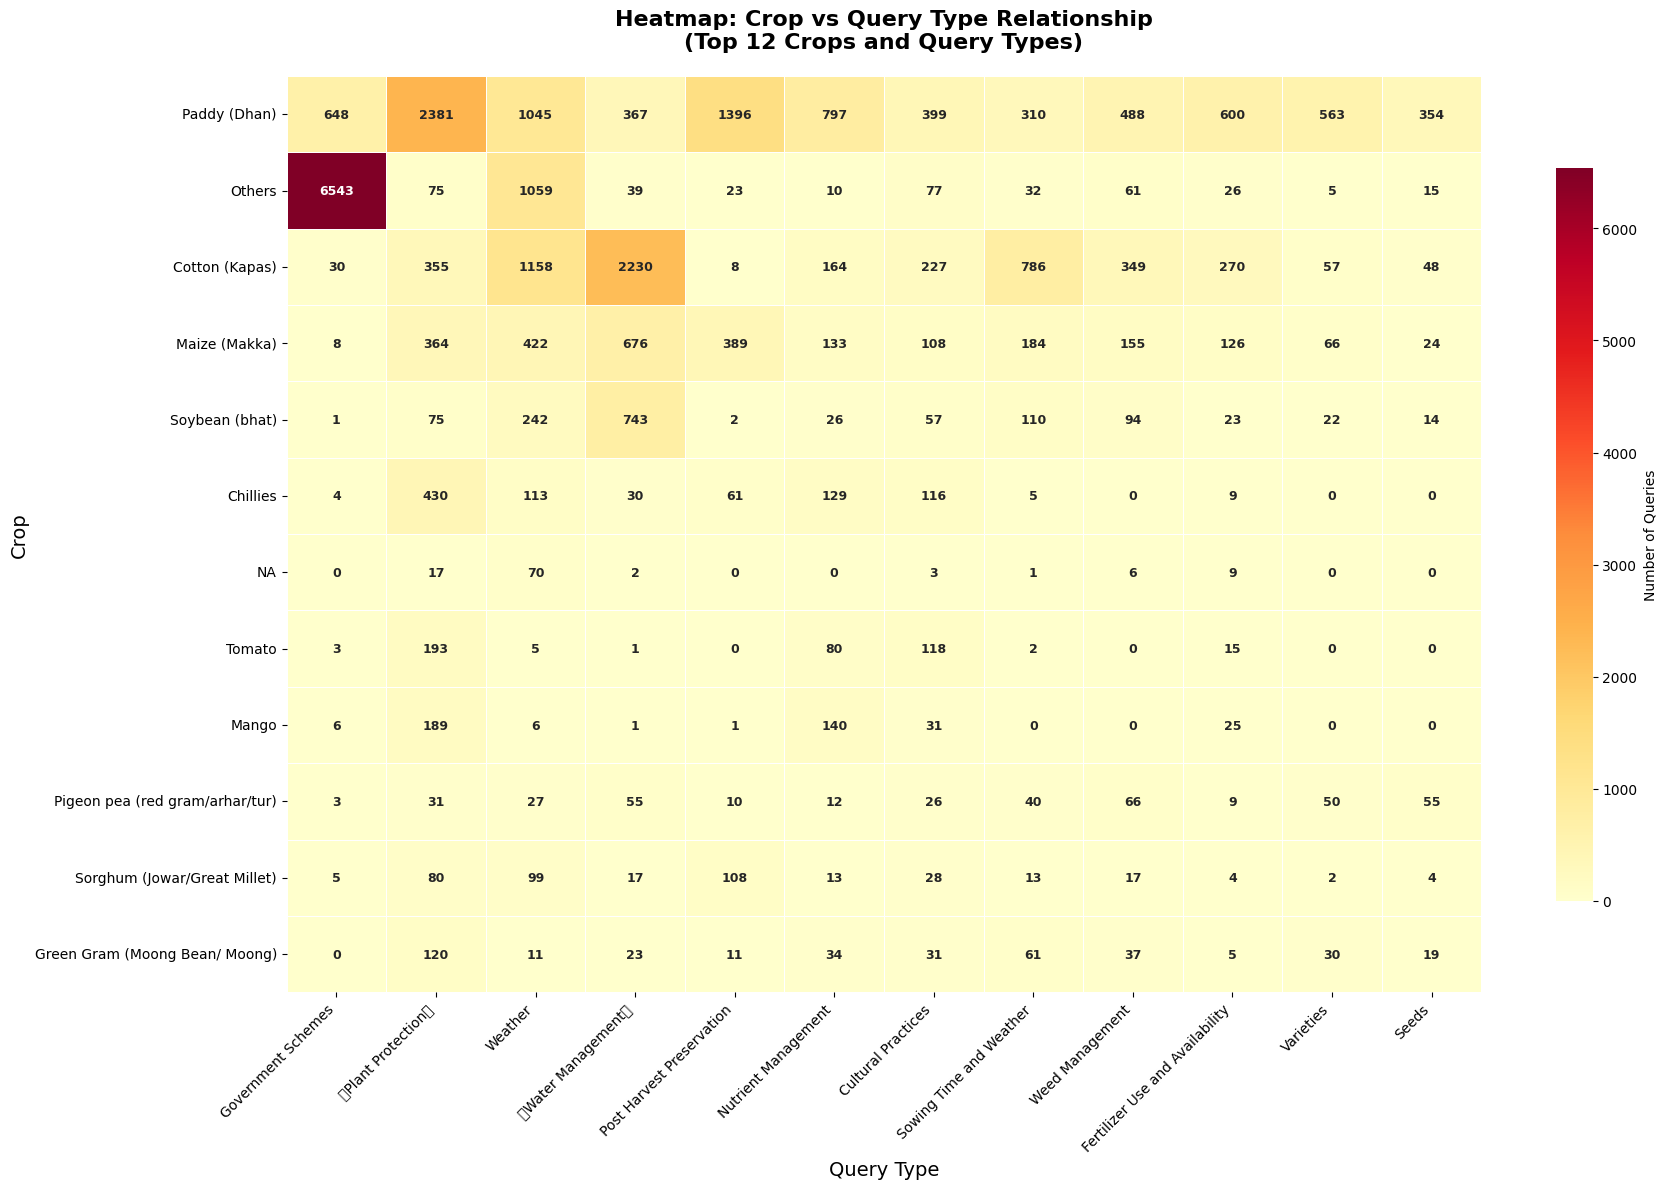


Heatmap Insights:
The heatmap shows which query types are most common for each crop.
Darker colors indicate stronger relationships between crops and query types.


In [54]:
# Cell 17: Heatmap - Crop vs Query Type - IMPROVED VERSION
print("=== CROP vs QUERY TYPE HEATMAP ANALYSIS ===")

plt.figure(figsize=(18, 12))

# Create cross-tabulation for heatmap
cross_tab = pd.crosstab(pandas_df['Crop'], pandas_df['QueryType'])

# Filter for top crops and query types
top_crops_list = pandas_df['Crop'].value_counts().head(12).index
top_query_types = pandas_df['QueryType'].value_counts().head(12).index

filtered_cross_tab = cross_tab.loc[top_crops_list, top_query_types]

# Create heatmap with better styling
sns.heatmap(filtered_cross_tab, annot=True, fmt='d', cmap='YlOrRd', 
            linewidths=0.5, linecolor='white',
            cbar_kws={'label': 'Number of Queries', 'shrink': 0.8},
            annot_kws={'fontsize': 9, 'fontweight': 'bold'})

plt.title('Heatmap: Crop vs Query Type Relationship\n(Top 12 Crops and Query Types)', 
          fontweight='bold', fontsize=16, pad=20)
plt.xlabel('Query Type', fontsize=14)
plt.ylabel('Crop', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

# Display some insights from the heatmap
print("\nHeatmap Insights:")
print("The heatmap shows which query types are most common for each crop.")
print("Darker colors indicate stronger relationships between crops and query types.")

=== ADVANCED MULTI-DIMENSIONAL ANALYSIS ===


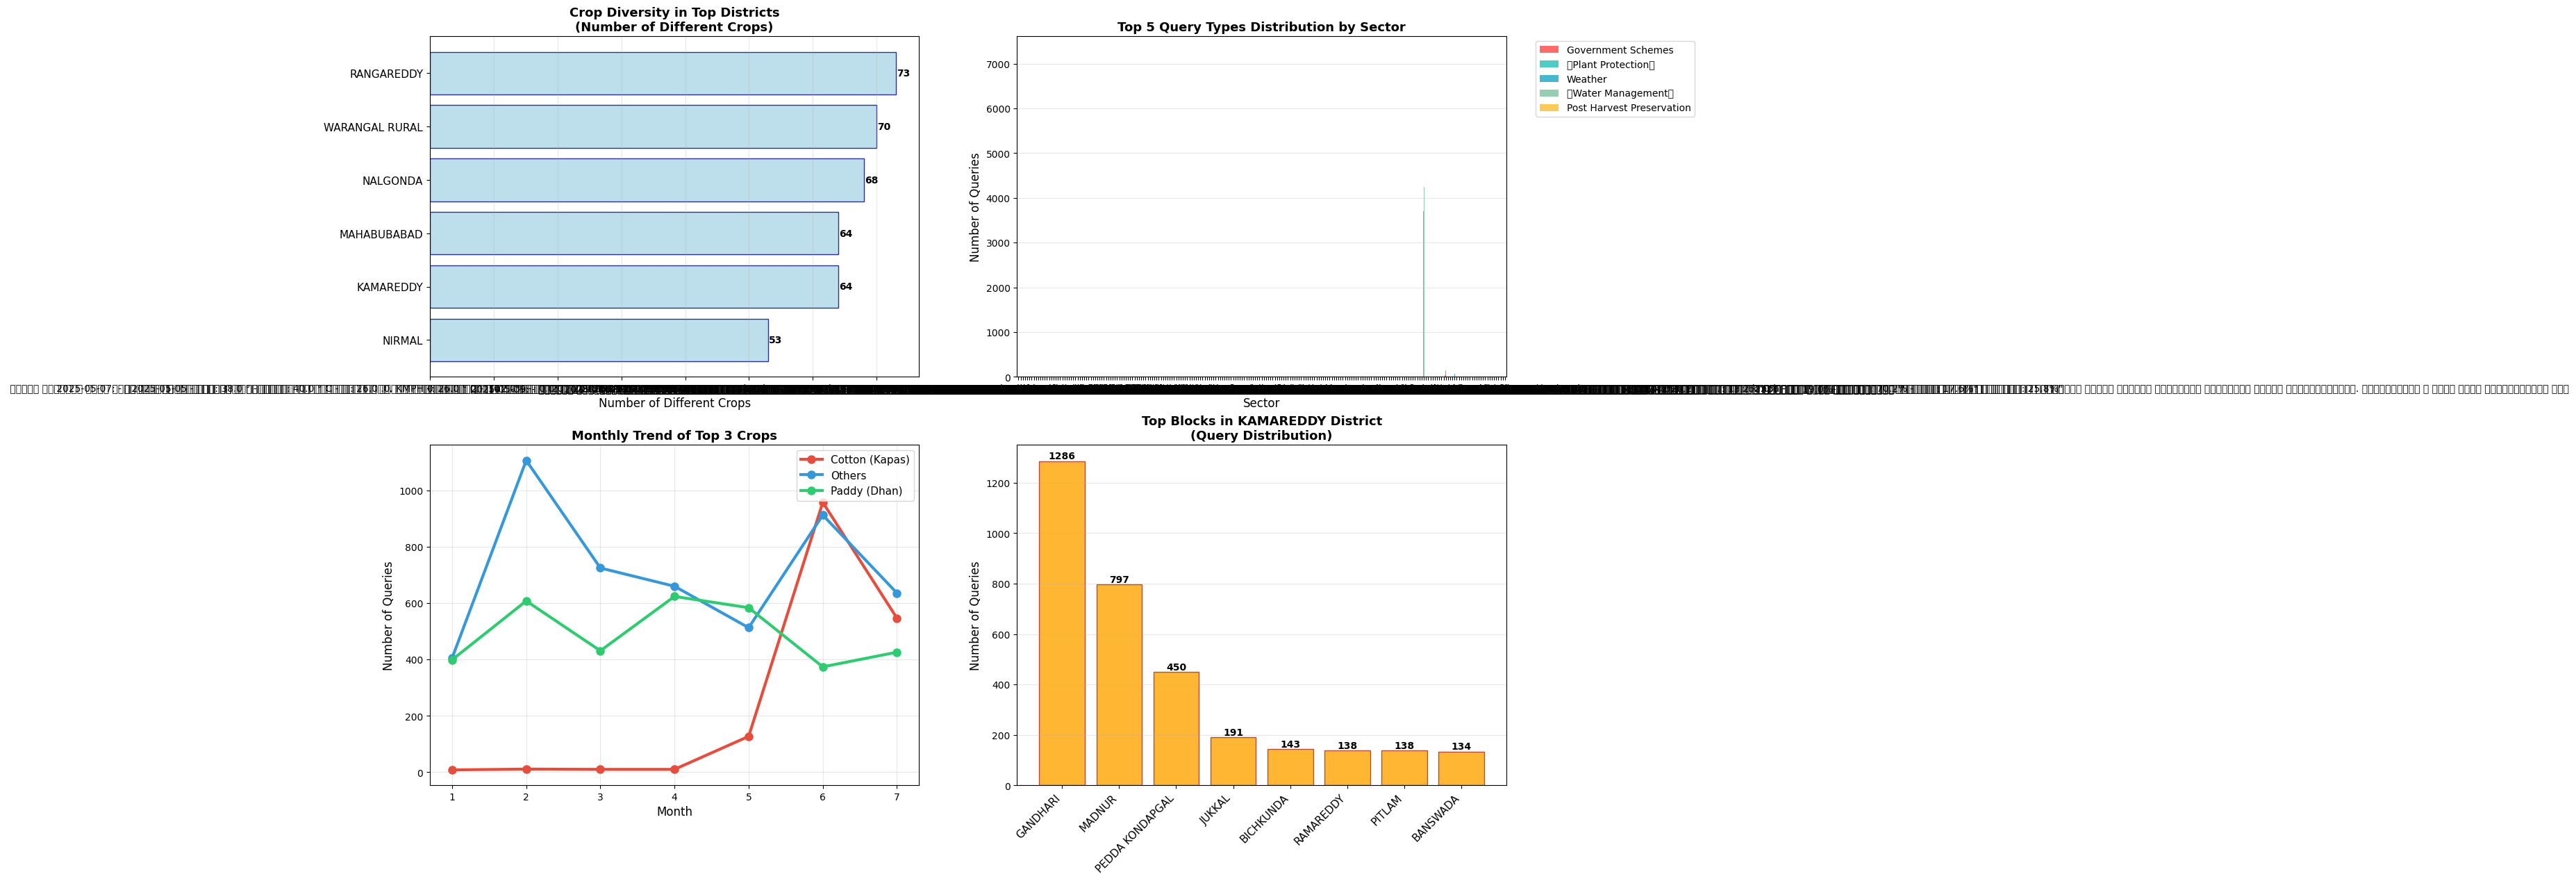


Additional Insights:
- KAMAREDDY district has the highest query volume
- Top 3 crops show varying monthly patterns
- Different sectors have different predominant query types


In [56]:
# Cell 18: Advanced Visualizations - IMPROVED VERSION
print("=== ADVANCED MULTI-DIMENSIONAL ANALYSIS ===")

fig, axes = plt.subplots(2, 2, figsize=(20, 14))

# Plot 1: Crop Diversity in Top Districts
top_districts_data = pandas_df[pandas_df['DistrictName'].isin(top_districts.head(6).index)]
district_crop_count = top_districts_data.groupby('DistrictName')['Crop'].nunique().sort_values(ascending=True)

bars1 = axes[0, 0].barh(range(len(district_crop_count)), district_crop_count.values, 
                       color='lightblue', edgecolor='navy', alpha=0.8)
axes[0, 0].set_yticks(range(len(district_crop_count)))
axes[0, 0].set_yticklabels(district_crop_count.index, fontsize=11)
axes[0, 0].set_title('Crop Diversity in Top Districts\n(Number of Different Crops)', 
                    fontweight='bold', fontsize=13)
axes[0, 0].set_xlabel('Number of Different Crops', fontsize=12)
axes[0, 0].grid(axis='x', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars1):
    width = bar.get_width()
    axes[0, 0].text(width + 0.1, bar.get_y() + bar.get_height()/2.,
                   f'{int(width)}', ha='left', va='center', fontweight='bold')

# Plot 2: Query Type distribution by Sector (Stacked Bar)
sector_query = pd.crosstab(pandas_df['Sector'], pandas_df['QueryType'])
top_query_types_for_stack = sector_query.sum().nlargest(5).index
sector_query_top = sector_query[top_query_types_for_stack]

sector_query_top.plot(kind='bar', ax=axes[0, 1], width=0.8, 
                     color=['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4', '#feca57'])
axes[0, 1].set_title('Top 5 Query Types Distribution by Sector', 
                    fontweight='bold', fontsize=13)
axes[0, 1].set_xlabel('Sector', fontsize=12)
axes[0, 1].set_ylabel('Number of Queries', fontsize=12)
axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=0)

# Plot 3: Monthly distribution of top crops
top_3_crops = pandas_df['Crop'].value_counts().head(3).index
monthly_crop_data = pandas_df[pandas_df['Crop'].isin(top_3_crops)]
monthly_crop_pivot = pd.crosstab(monthly_crop_data['month'], monthly_crop_data['Crop'])

colors_crop = ['#e74c3c', '#3498db', '#2ecc71']
for i, crop in enumerate(monthly_crop_pivot.columns):
    axes[1, 0].plot(monthly_crop_pivot.index, monthly_crop_pivot[crop], 
                   marker='o', linewidth=3, markersize=8, label=crop, color=colors_crop[i])
    
axes[1, 0].set_title('Monthly Trend of Top 3 Crops', fontweight='bold', fontsize=13)
axes[1, 0].set_xlabel('Month', fontsize=12)
axes[1, 0].set_ylabel('Number of Queries', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend(fontsize=11)
axes[1, 0].set_xticks(monthly_crop_pivot.index)

# Plot 4: Block-level analysis for top district
top_district = top_districts.index[0]
district_data = pandas_df[pandas_df['DistrictName'] == top_district]
block_analysis = district_data['BlockName'].value_counts().head(8)

bars4 = axes[1, 1].bar(range(len(block_analysis)), block_analysis.values, 
                      color='orange', edgecolor='brown', alpha=0.8)
axes[1, 1].set_xticks(range(len(block_analysis)))
axes[1, 1].set_xticklabels(block_analysis.index, rotation=45, ha='right', fontsize=11)
axes[1, 1].set_title(f'Top Blocks in {top_district} District\n(Query Distribution)', 
                    fontweight='bold', fontsize=13)
axes[1, 1].set_ylabel('Number of Queries', fontsize=12)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars4):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Additional insights
print(f"\nAdditional Insights:")
print(f"- {top_district} district has the highest query volume")
print(f"- Top 3 crops show varying monthly patterns")
print(f"- Different sectors have different predominant query types")